# Flood Prediction
**Autoren**: Anonymous 1, Alma Binti Morsidi(3372342)

Ziel dieses Notebooks ist die Prognose des Pegelstands an einer Messstation anhand des Niederschlags und der time-lags des beobachteten Pegels für 6 Stunden im Voraus. In diesem Notebook werden 3 Machine Learning Modelle verwendet und bewertet, nämlich ein lineares Modell, ein Regressions Tree(+verwandte Methoden) und ein neuronales Netz.

Inhalt:
  
  1. Vorverarbeitung der Daten
  2. Linear Modell
  3. Regression Tree
  4. Neuronales Netz


In [1]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import het_breuschpagan
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, GRU,InputLayer,Dense, Activation,SimpleRNN
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils import to_categorical
from keras.utils import plot_model

## 1. Vorverarbeitung der Daten


### 1.1. Daten laden
Es wurden zwei Datensätze bereitgestellt, nämlich `Q_hourly_ID16425004.dat` und `pr_hourly_DWD_ID1550.dat`, die das folgende Format haben:
  
- `Q_hourly_ID16425004.dat`: Der Abfluss Q ist der durchschnittlich gemessene Abfluss der Partnach in einer Stunde.
Der Abfluss Q gibt das Volumen V an, das in einem Fließgewässer in einer bestimmten Zeit t eine vollständige Querschnittsfläche F passiert, d. h. den Volumenstrom des Wasserkörpers durch F. Damit ergibt sich für den Abfluss die Formel Q = V  /t. Seine Einheit ist also m³/s.
- `pr_hourly_DWD_ID1550.dat`: Diese Daten, die die Niederschlagsmenge in der Region Garmisch-Partenkirchen darstellen, stammen vom Deutschen Wetterdienst und werden stündlich gemessen.  PR bedeutet die Niederschlagsmenge in mm.

Der erste Datensatz beginnt jedoch im Jahr 1920 und endet 2020. Der zweite Datensatz ist nur von 1995 bis 2019 verfügbar. Aufgrund dieser Inkonsistenz haben wir entschieden, alle Datensätze vor 1995 und nach 2019 auszuschneiden und beide Datensätze in einem Datenframe zusammenzuführen, um ein geeigneteres Format für Machine Learning-Modelle zu erhalten.

In [2]:
# load both dataset to dataframe
q_hour= pd.read_csv('./data/Q_hourly_ID16425004.dat',)
print(q_hour.head())

pr_hour=pd.read_csv('./data/pr_hourly_DWD_ID1550.dat',sep='\t',names=['Year','Month','Day','Hour','Precipitation'])
pr_hour['timestamp'] = pd.to_datetime(pr_hour[['Year', 'Month', 'Day', 'Hour']])
print(pr_hour.head())

# store the first and last date of recorded precipitation
start_date = pr_hour['timestamp'].min()
end_date = pr_hour['timestamp'].max()

print('First Date in pr_hour:', start_date)
print('Last Date in pr_hour:', end_date)


   Year  Month  Day  Hour     Q
0  1920     11    1     0  2.46
1  1920     11    1     1  2.46
2  1920     11    1     2  2.46
3  1920     11    1     3  2.46
4  1920     11    1     4  2.46
   Year  Month  Day  Hour  Precipitation           timestamp
0  1995      9    1     0            0.0 1995-09-01 00:00:00
1  1995      9    1     1            0.0 1995-09-01 01:00:00
2  1995      9    1     2            0.0 1995-09-01 02:00:00
3  1995      9    1     3            0.0 1995-09-01 03:00:00
4  1995      9    1     4            0.0 1995-09-01 04:00:00
First Date in pr_hour: 1995-09-01 00:00:00
Last Date in pr_hour: 2019-12-31 23:00:00


In [ ]:
pr_hour

,Year,Month,Day,Hour,Precipitation,timestamp
0,1995,9,1,0,0.0,1995-09-01 00:00:00
1,1995,9,1,1,0.0,1995-09-01 01:00:00
2,1995,9,1,2,0.0,1995-09-01 02:00:00
3,1995,9,1,3,0.0,1995-09-01 03:00:00
4,1995,9,1,4,0.0,1995-09-01 04:00:00
...,...,...,...,...,...,...
213307,2019,12,31,19,0.0,2019-12-31 19:00:00
213308,2019,12,31,20,0.0,2019-12-31 20:00:00
213309,2019,12,31,21,0.0,2019-12-31 21:00:00
213310,2019,12,31,22,0.0,2019-12-31 22:00:00


In [ ]:

# merge both datasets
df_combined = pd.merge(q_hour, pr_hour, on=['Year', 'Month', 'Day', 'Hour'], how='left')

# convert time related column to datetime format
df_combined['timestamp'] = pd.to_datetime(df_combined[['Year', 'Month', 'Day', 'Hour']])
df_combined = df_combined.drop(['Year', 'Month', 'Day', 'Hour'], axis=1)

# limit the dataset for a certain date as the precipitation values for certain dates are not available
df_combined =  df_combined[(df_combined['timestamp'] >= start_date) & (df_combined['timestamp'] <= end_date)]

# set timestamp to be index for our dataframe
df_combined.set_index('timestamp', inplace=True)
#rename Q to flow_rate
df_combined.rename(columns={'Q': 'flow_rate'}, inplace=True)

df_combined.head(10)

,flow_rate,Precipitation
timestamp,,
1995-09-01 00:00:00,11.888,0.0
1995-09-01 01:00:00,11.745,0.0
1995-09-01 02:00:00,11.601,0.0
1995-09-01 03:00:00,11.457,0.0
1995-09-01 04:00:00,11.313,0.0
1995-09-01 05:00:00,11.170,0.0
1995-09-01 06:00:00,11.026,0.1
1995-09-01 07:00:00,10.882,0.2
1995-09-01 08:00:00,8.551,0.2


### 1.2. Feature Engineering
Nun werden wir lagged-time Features für die pr- und Q-Werte für bis zu 48 Stunden hinzufügen, um die Korrelation zu testen und einen besseren Überblick über die statistische Beziehung der Variablen zu erhalten.

Eine weitere Spalte mit dem Q-Wert nach 6 Stunden wird ebenfalls aufgenommen `fr_target`, die als Zielgröße für alle unsere Modelle verwendet wird.

In [ ]:
#add past pr values for correlation testing
df_combined['pr_3h_before'] = df_combined['Precipitation'].shift(3)
df_combined['pr_6h_before'] = df_combined['Precipitation'].shift(6)
df_combined['pr_9h_before'] = df_combined['Precipitation'].shift(9)
df_combined['pr_12h_before'] = df_combined['Precipitation'].shift(12)
df_combined['pr_24h_before'] = df_combined['Precipitation'].shift(24)
df_combined['pr_36h_before'] = df_combined['Precipitation'].shift(36)
df_combined['pr_48h_before'] = df_combined['Precipitation'].shift(48)

#add past Q values for correlation testing
df_combined['fr_3h_before'] = df_combined['flow_rate'].shift(3)
df_combined['fr_6h_before'] = df_combined['flow_rate'].shift(6)
df_combined['fr_9h_before'] = df_combined['flow_rate'].shift(9)
df_combined['fr_12h_before'] = df_combined['flow_rate'].shift(12)
df_combined['fr_24h_before'] = df_combined['flow_rate'].shift(24)

#add a new column that record Q after 6 hours(target variable)
df_combined['fr_target'] = df_combined['flow_rate'].shift(-6)
df_combined.head(5)


,flow_rate,Precipitation,pr_3h_before,pr_6h_before,pr_9h_before,pr_12h_before,pr_24h_before,pr_36h_before,pr_48h_before,fr_3h_before,fr_6h_before,fr_9h_before,fr_12h_before,fr_24h_before,fr_target
timestamp,,,,,,,,,,,,,,,
1995-09-01 00:00:00,11.888,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.026
1995-09-01 01:00:00,11.745,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.882
1995-09-01 02:00:00,11.601,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.551
1995-09-01 03:00:00,11.457,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,11.888,NaN,NaN,NaN,NaN,10.758
1995-09-01 04:00:00,11.313,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,11.745,NaN,NaN,NaN,NaN,10.109


### 1.3. Daten bereinigen

In [ ]:
df_combined.describe()

,flow_rate,Precipitation,pr_3h_before,pr_6h_before,pr_9h_before,pr_12h_before,pr_24h_before,pr_36h_before,pr_48h_before,fr_3h_before,fr_6h_before,fr_9h_before,fr_12h_before,fr_24h_before,fr_target
count,213312.000000,213312.000000,213309.000000,213306.000000,213303.000000,213300.000000,213288.000000,213276.000000,213264.000000,213309.000000,213306.000000,213303.000000,213300.000000,213288.000000,213306.000000
mean,4.029294,-398.788224,-398.793832,-398.799441,-398.805050,-398.810659,-398.833097,-398.855537,-398.877980,4.029323,4.029352,4.029381,4.029410,4.029526,4.029083
std,3.136641,6303.568137,6303.612287,6303.656438,6303.700589,6303.744741,6303.921361,6304.097994,6304.274643,3.136653,3.136666,3.136678,3.136691,3.136741,3.136432
min,0.162000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,0.162000,0.162000,0.162000,0.162000,0.162000,0.162000
25%,1.788000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.788000,1.788000,1.788000,1.788000,1.788000,1.788000
50%,3.167000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.167000,3.167000,3.167000,3.167000,3.168000,3.167000
75%,5.377000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.377000,5.377000,5.377000,5.377000,5.378000,5.377000
max,64.457000,37.100000,37.100000,37.100000,37.100000,37.100000,37.100000,37.100000,37.100000,64.457000,64.457000,64.457000,64.457000,64.457000,64.457000


Aufgrund der Lag-Zeit-Spalten gibt es ein paar fehlende Werte, die wir weggelassen haben.

In [ ]:
# Test for any missing values
missing_values = df_combined.isna().sum()
print('Total missing values:')
print(missing_values)

# drop missing values
df_combined = df_combined.dropna()


Total missing values:
flow_rate         0
Precipitation     0
pr_3h_before      3
pr_6h_before      6
pr_9h_before      9
pr_12h_before    12
pr_24h_before    24
pr_36h_before    36
pr_48h_before    48
fr_3h_before      3
fr_6h_before      6
fr_9h_before      9
fr_12h_before    12
fr_24h_before    24
fr_target         6
dtype: int64


In [ ]:
missing_values = df_combined.isna().sum()
print('Total missing values:')
print(missing_values)
#df_combined

Total missing values:
flow_rate        0
Precipitation    0
pr_3h_before     0
pr_6h_before     0
pr_9h_before     0
pr_12h_before    0
pr_24h_before    0
pr_36h_before    0
pr_48h_before    0
fr_3h_before     0
fr_6h_before     0
fr_9h_before     0
fr_12h_before    0
fr_24h_before    0
fr_target        0
dtype: int64


Es gab auch einige negative Werte, die durch 0 ersetzt wurden.

In [ ]:
# Test for negative values (there are no negative Q Values, only precipitation)
negative_values = df_combined.apply(lambda x: (x < 0).sum())
print('Negative values:')
print(negative_values)

# replace all negative values with 0
df_combined = df_combined.applymap(lambda x: 0 if x < 0 else x)
#df_combined

Negative values:
flow_rate          0
Precipitation    850
pr_3h_before     850
pr_6h_before     850
pr_9h_before     850
pr_12h_before    850
pr_24h_before    851
pr_36h_before    851
pr_48h_before    851
fr_3h_before       0
fr_6h_before       0
fr_9h_before       0
fr_12h_before      0
fr_24h_before      0
fr_target          0
dtype: int64


In [ ]:
negative_values = df_combined.apply(lambda x: (x < 0).sum())
print('Negative values:')
print(negative_values)

Negative values:
flow_rate        0
Precipitation    0
pr_3h_before     0
pr_6h_before     0
pr_9h_before     0
pr_12h_before    0
pr_24h_before    0
pr_36h_before    0
pr_48h_before    0
fr_3h_before     0
fr_6h_before     0
fr_9h_before     0
fr_12h_before    0
fr_24h_before    0
fr_target        0
dtype: int64


Jetzt werden wir versuchen, positive Outliers in den Daten zu finden

In [ ]:

high_wlevel= df_combined[df_combined['flow_rate'] > 40]
print(len(high_wlevel))
high_pr = df_combined[df_combined['Precipitation'] > 20]
print(len(high_pr))


47
12


Es gibt ein paar hohe Niederschlags- und Flowrate-Werte, die aber nicht so hoch sind, dass sie auf falsche Daten hindeuten.



### 1.4. Datenvisualisierung

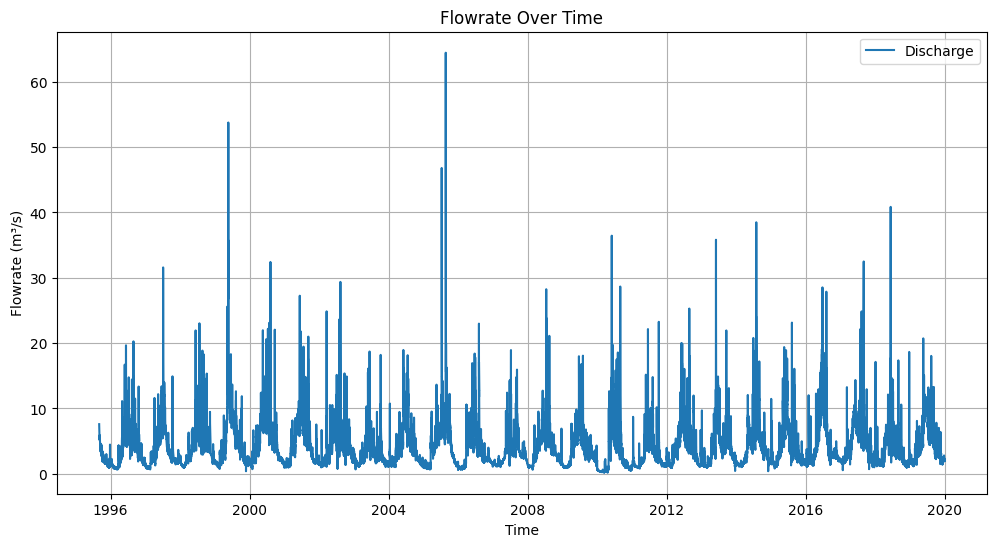

In [ ]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['flow_rate'], label='Discharge')
plt.title('Flowrate Over Time')
plt.xlabel('Time')
plt.ylabel('Flowrate (m³/s)')
plt.legend()
plt.grid(True)
plt.show()

Jährlich wiederholende oder saisonale Schwankungen sind in den Daten zu erkennen. Dies kann auf natürliche Zyklen wie Veränderungen bei Niederschlag, Temperatur oder Schneeschmelze hinweisen.

Es sind jedoch auch extreme Abflusswerte (Ausreißer) zu erkennen, die auf extreme Wetterbedingungen hindeuten können, die den Abfluss des Flusses erheblich beeinflussen.

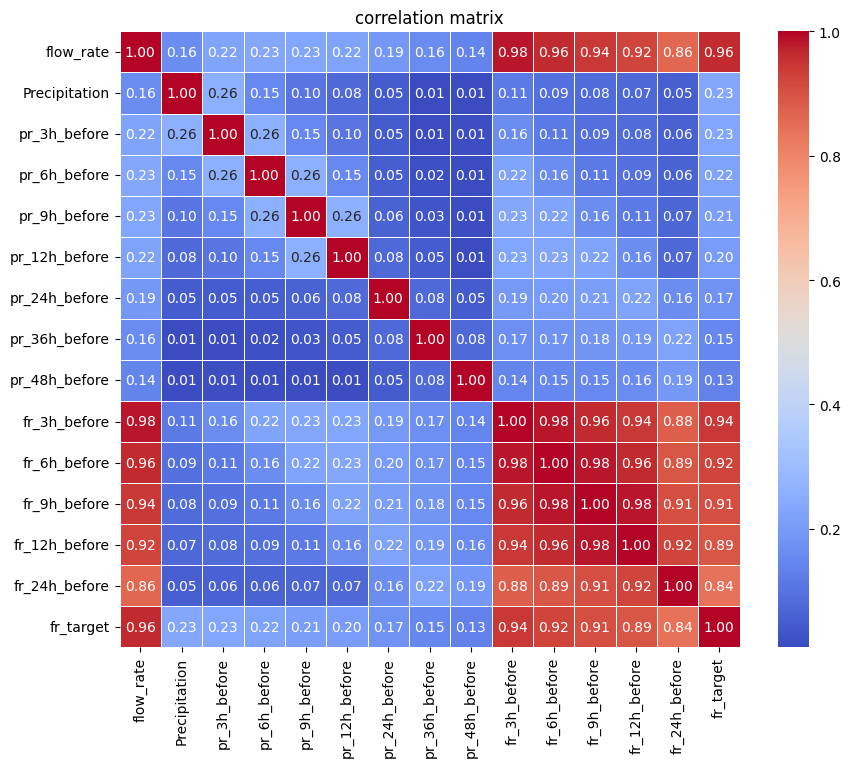

In [ ]:
#create a correlation heatmap to find best time-lag variables
correlation_matrix = df_combined.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('correlation matrix')
plt.show()

Die Heatmap zeigt eine geringe Korrelation zwischen den vergangenen pr-Werten und unserem Ziel.Der aktuelle Flowrate-Wert weist eine sehr hohe Korrelation auf, ebenso wie die vergangenen Flowrate-Werte.


In [ ]:
# drop unwamted columns
columns_to_drop= ['pr_24h_before','pr_12h_before','pr_9h_before','pr_3h_before','pr_6h_before','pr_36h_before','pr_48h_before','fr_3h_before','fr_6h_before','fr_9h_before','fr_12h_before']
X=df_combined.drop(columns=columns_to_drop)

# split into X and y(target)
y=X['fr_target']
X=X.drop('fr_target',axis=1)
print(X.head())

                     flow_rate  Precipitation  fr_24h_before
timestamp                                                   
1995-09-03 00:00:00      7.596            0.0          8.809
1995-09-03 01:00:00      7.562            0.0          8.750
1995-09-03 02:00:00      7.529            0.0          8.688
1995-09-03 03:00:00      7.495            0.0          8.626
1995-09-03 04:00:00      7.461            0.0          8.564


In [ ]:
y

timestamp
1995-09-03 00:00:00    7.393
1995-09-03 01:00:00    7.360
1995-09-03 02:00:00    7.326
1995-09-03 03:00:00    7.292
1995-09-03 04:00:00    7.258
                       ...  
2019-12-31 13:00:00    1.965
2019-12-31 14:00:00    1.965
2019-12-31 15:00:00    1.965
2019-12-31 16:00:00    1.965
2019-12-31 17:00:00    1.965
Name: fr_target, Length: 213258, dtype: float64

## 2. Linear Modell

In [ ]:
#split the data into train,test set and add intercept column
X_train_lin1,X_test_lin1,y_train,y_test = train_test_split(X,y,test_size=0.20)
X_train_lin = sm.add_constant(X_train_lin1) # add intercept column
X_test_lin = sm.add_constant(X_test_lin1) # add intercept column
X_train_lin.head()

,const,flow_rate,Precipitation,fr_24h_before
timestamp,,,,
2001-05-15 04:00:00,1.0,6.754,0.0,6.535
2000-12-18 16:00:00,1.0,1.803,0.0,1.816
2000-11-18 15:00:00,1.0,2.162,0.0,2.255
2002-09-08 10:00:00,1.0,3.637,0.0,3.637
2001-02-28 07:00:00,1.0,1.134,0.0,1.206


In [ ]:
olsmod_lin = sm.OLS(y_train, X_train_lin) # definition of model
olsres_lin = olsmod_lin.fit() # parameter estimation on Train set - model name olsres_lin

# Get the summary of the model
olsres_lin_summary = olsres_lin.summary()
print(olsres_lin_summary)

                            OLS Regression Results                            
Dep. Variable:              fr_target   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 8.374e+05
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:36:18   Log-Likelihood:            -2.0193e+05
No. Observations:              170606   AIC:                         4.039e+05
Df Residuals:                  170602   BIC:                         4.039e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1080      0.003     33.825

In [ ]:
y_hat_lin_tr = olsres_lin.predict(X_train_lin) # predictions on training set
y_hat_lin_te = olsres_lin.predict(X_test_lin) # predictions on test set
y_hat_lin_te

timestamp
1995-09-24 23:00:00    3.831024
1999-10-25 01:00:00    2.470366
2012-08-22 12:00:00    3.476794
2014-04-11 04:00:00    2.249818
2008-11-24 05:00:00    2.226535
                         ...   
2012-02-10 22:00:00    1.170065
2018-04-25 23:00:00    7.090780
1998-11-03 13:00:00    4.546220
2001-12-25 22:00:00    1.557898
2002-05-17 07:00:00    3.652638
Length: 42652, dtype: float64

In [ ]:

# calculate RMSE for training- and test set
rmse_lin_tr = sqrt(mean_squared_error(y_hat_lin_tr,y_train))
rmse_lin_test = sqrt(mean_squared_error(y_hat_lin_te,y_test))

print('Trainingsfehler:',rmse_lin_tr)
print('Testfehler:',rmse_lin_test)

Trainingsfehler: 0.7902975226045874
Testfehler: 0.8097751713387942


Text(0, 0.5, 'frequency')

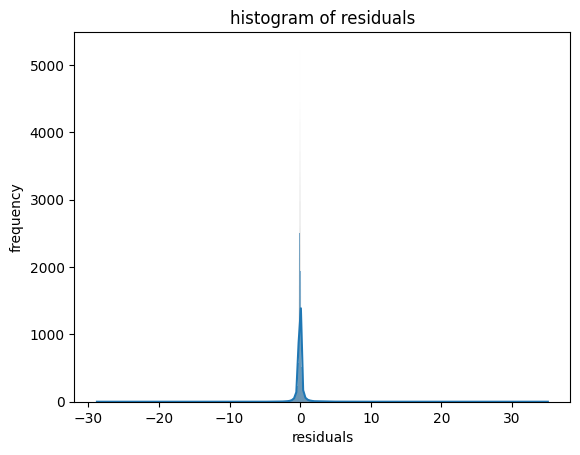

In [ ]:
#plot the residuals
residuals= olsres_lin.resid
sns.histplot(residuals,kde=True)
plt.title('histogram of residuals')
plt.xlabel('residuals')
plt.ylabel('frequency')

Die Struktur der Verteilung von Residual sieht gut aus.

In [ ]:
# Create a new dataframe with all predicted y values from model
y_hat_lin = pd.concat([y_hat_lin_tr, y_hat_lin_te])
y_hat_lin.sort_index(inplace=True)
y_hat_lin

timestamp
1995-09-03 00:00:00    7.447281
1995-09-03 01:00:00    7.413467
1995-09-03 02:00:00    7.380414
1995-09-03 03:00:00    7.346452
1995-09-03 04:00:00    7.312490
                         ...   
2019-12-31 13:00:00    1.990109
2019-12-31 14:00:00    1.994933
2019-12-31 15:00:00    1.995842
2019-12-31 16:00:00    1.993430
2019-12-31 17:00:00    1.998254
Length: 213258, dtype: float64

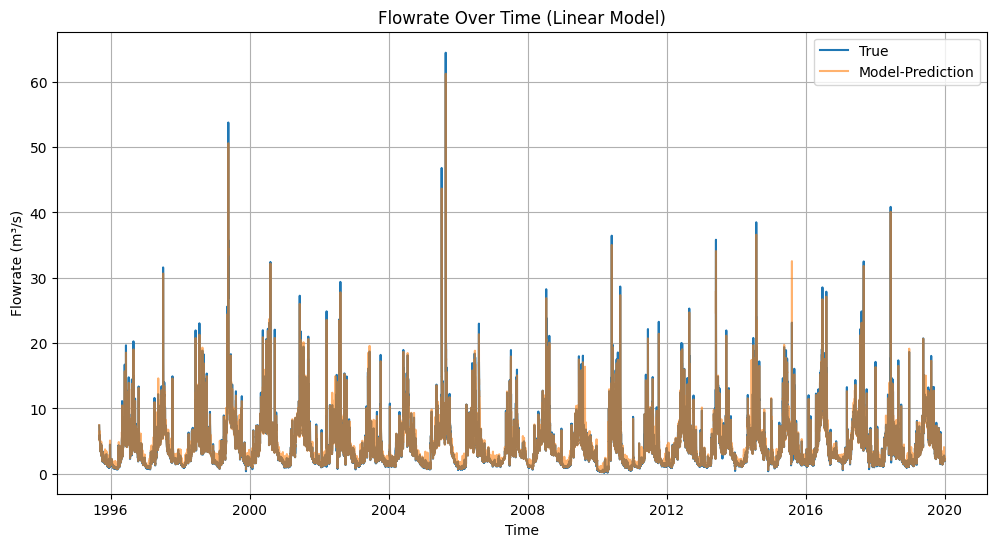

In [ ]:
# Plot the prediction over time
# Compare the value of prediction with true value of discharge
plt.figure(figsize=(12, 6))
plt.plot(y,label='True')
plt.plot(y_hat_lin,label='Model-Prediction',alpha=0.6)
plt.title('Flowrate Over Time (Linear Model)')
plt.xlabel('Time')
plt.ylabel('Flowrate (m³/s)')
plt.legend()
plt.grid(True)
plt.show()

## 3. Regression Tree

In [ ]:
 # Split data to training- and test set
 X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.3)

### 3.1. Einfacher Regression Tree

In [ ]:

# base model
flood_tree=DecisionTreeRegressor()

# fit models to our training set
flood_tree.fit(X_train_tree,y_train_tree)

# find predicted value y hat values using model
y_hat_train = flood_tree.predict(X_train_tree)
y_hat_test = flood_tree.predict(X_test_tree)

# calculate RMSE for training- and test set
rmseTree_tr = sqrt(mean_squared_error(y_hat_train,y_train_tree))
rmseTree_test = sqrt(mean_squared_error(y_hat_test,y_test_tree))


print('Trainingsfehler:',rmseTree_tr)
print('Testfehler:',rmseTree_test)
# Training and test error are significantly different
# Suggest model overfitted on training set

Trainingsfehler: 0.05601330493338052
Testfehler: 0.9913035596284544


### 3.2. Regression Tree mit festgelegten max. Tiefe
Wir finden zunächst die optimale Tiefe für unseren Baum, indem wir den RMSE als Fehlermaß verwenden.

In [ ]:
# Restricted depth of simple regression tree
# Vary max depth to find optimal depth of tree which gives the best performance
RMSE_tr_list = []
RMSE_te_list = []
tree_score_list = []

for k in range(1,150):
    # Modell spezifizieren (max. Tiefe = 3)
    flood_tree=DecisionTreeRegressor(max_depth=k)

    flood_tree.fit(X_train_tree,y_train_tree)

    y_hat_train = flood_tree.predict(X_train_tree)
    y_hat_test = flood_tree.predict(X_test_tree)

    rmseTree_tr = sqrt(mean_squared_error(y_hat_train,y_train_tree))
    rmseTree_test = sqrt(mean_squared_error(y_hat_test,y_test_tree))
    tree_score = flood_tree.score(X_test_tree, y_test_tree, sample_weight=None)

    RMSE_tr_list.append(rmseTree_tr)
    RMSE_te_list.append(rmseTree_test)
    tree_score_list.append(tree_score)

RMSE_opt_depth = min(RMSE_te_list)
opt_depth = RMSE_te_list.index(RMSE_opt_depth)+1

print('Optimal Tiefe:',opt_depth)
print('Trainingsfehler:',RMSE_tr_list[opt_depth-1])
print('Testfehler:',RMSE_opt_depth)
print('Overfitting startet ab:', RMSE_tr_list.index(min(RMSE_tr_list))+1)


Optimal Tiefe: 8
Trainingsfehler: 0.6883315721812321
Testfehler: 0.7668248185059499
Overfitting startet ab: 114


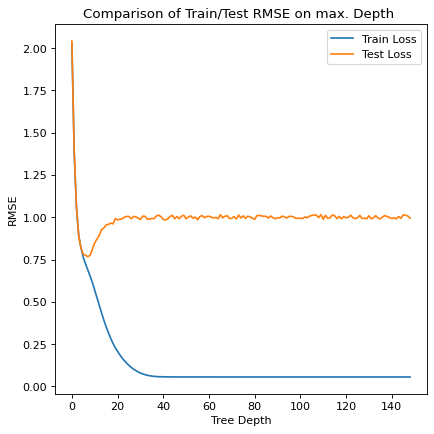

In [ ]:
# Plot size
plt.figure(figsize=(6, 6), dpi=80)

plt.plot(RMSE_tr_list,  label='Train Loss');
plt.plot(RMSE_te_list, label='Test Loss');

plt.xlabel('Tree Depth')
plt.ylabel('RMSE')
plt.title('Comparison of Train/Test RMSE on max. Depth ')

#position of labels
plt.legend();
plt.legend();

### 3.3. Bagged Regression Tree

In [ ]:
# bagging

FloodBagReg = BaggingRegressor(estimator=DecisionTreeRegressor(),
                    n_estimators=100, random_state=0, bootstrap=True).fit(X_train_tree, y_train_tree)

y_hat_train_Bag = FloodBagReg.predict(X_train_tree)
y_hat_test_Bag = FloodBagReg.predict(X_test_tree)

rmseTree_Bag_tr = sqrt(mean_squared_error(y_hat_train_Bag,y_train_tree))
rmseTree_Bag_test = sqrt(mean_squared_error(y_hat_test_Bag,y_test_tree))

print('Trainings error:',rmseTree_Bag_tr)
print('Test error:',rmseTree_Bag_test)


Trainings error: 0.28738775151465434
Test error: 0.7507334548800847


### 3.4. Random Forest

In [ ]:
# random forest

RF_Flood=RandomForestRegressor(n_estimators=100)
RF_Flood=RF_Flood.fit(X_train_tree,y_train_tree)

y_hat_train_RF = RF_Flood.predict(X_train_tree)
y_hat_test_RF = RF_Flood.predict(X_test_tree)

rmseTree_RF_tr = sqrt(mean_squared_error(y_hat_train_RF,y_train_tree))
rmseTree_RF_test = sqrt(mean_squared_error(y_hat_test_RF,y_test_tree))

print('Trainings error:',rmseTree_RF_tr)
print('Test error:',rmseTree_RF_test)

Trainings error: 0.28630059209648995
Test error: 0.7516787821932723


### 3.5. Adaptive Boosting (AdaBoost)

In [ ]:
# ada boost

ada_Flood=AdaBoostRegressor(estimator=DecisionTreeRegressor())
ada_Flood=ada_Flood.fit(X_train_tree,y_train_tree)

y_hat_train_ada = ada_Flood.predict(X_train_tree)
y_hat_test_ada = ada_Flood.predict(X_test_tree)

rmseTree_ada_tr = sqrt(mean_squared_error(y_hat_train_ada,y_train_tree))
rmseTree_ada_test = sqrt(mean_squared_error(y_hat_test_ada,y_test_tree))


print('Trainings error:',rmseTree_ada_tr)
print('Test error:',rmseTree_ada_test)

Trainings error: 0.19713390221072355
Test error: 0.7687414373603587


### 3.6. Gradient Boosting

In [ ]:
# gradient boosting

GBC_Flood=GradientBoostingRegressor(n_estimators=100,random_state=0)
GBC_Flood=GBC_Flood.fit(X_train_tree,y_train_tree)

y_hat_train_GBC = GBC_Flood.predict(X_train_tree)
y_hat_test_GBC = GBC_Flood.predict(X_test_tree)

rmseTree_GBC_tr = sqrt(mean_squared_error(y_hat_train_GBC,y_train_tree))
rmseTree_GBC_test = sqrt(mean_squared_error(y_hat_test_GBC,y_test_tree))

print('Trainings error:',rmseTree_GBC_tr)
print('Test error:',rmseTree_GBC_test)

Trainings error: 0.7096808004928886
Test error: 0.7368050359364569


### 3.7. Vergleich der Tree Modelle

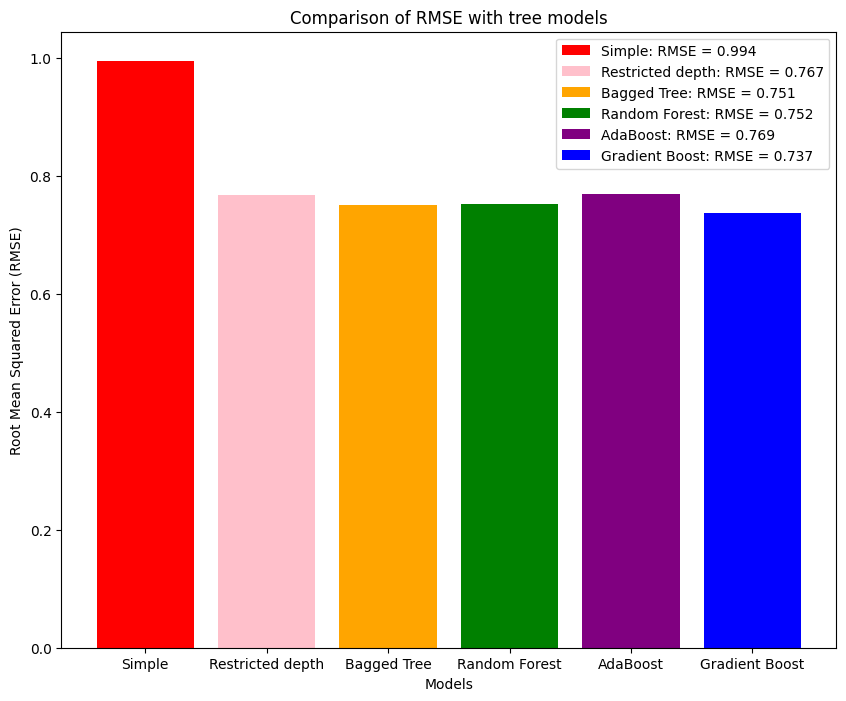

In [ ]:
# comparison

models = ['Simple','Restricted depth','Bagged Tree', 'Random Forest','AdaBoost','Gradient Boost']
rmse_values = [rmseTree_test,RMSE_opt_depth, rmseTree_Bag_test,rmseTree_RF_test,rmseTree_ada_test,rmseTree_GBC_test]

plt.figure(figsize=(10, 8))
bars = plt.bar(models, rmse_values, color=['red','pink','orange','green','purple','blue'])

legend_labels = [f'{model}: RMSE = {rmse:.3f}' for model, rmse in zip(models, rmse_values)]

# Add labels and title
plt.legend(bars, legend_labels,loc = 'upper right')
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of RMSE with tree models')
plt.show()


Der Gradient-Boosted-Tree hat den niedrigsten RMSE, ist also unser Top-Modell für Regressions Tree.

Jetzt werden der vom Gradient-Boosted-Tree vorhergesagte Wert und der wahre Wert in einem Graphen dargestellt.

In [ ]:
y_hat_GBC1 = pd.Series(data=y_hat_train_GBC, index=y_train_tree.index, name='fr_target')
y_hat_GBC2 = pd.Series(data=y_hat_test_GBC, index=y_test_tree.index, name='fr_target')
y_hat_GBC = pd.concat([y_hat_GBC1, y_hat_GBC2])
y_hat_GBC.sort_index(inplace=True)
y_hat_GBC


timestamp
1995-09-03 00:00:00    7.482338
1995-09-03 01:00:00    7.482338
1995-09-03 02:00:00    7.482338
1995-09-03 03:00:00    7.482338
1995-09-03 04:00:00    7.261677
                         ...   
2019-12-31 13:00:00    1.964505
2019-12-31 14:00:00    1.977713
2019-12-31 15:00:00    1.977713
2019-12-31 16:00:00    1.964505
2019-12-31 17:00:00    1.977713
Name: fr_target, Length: 213258, dtype: float64

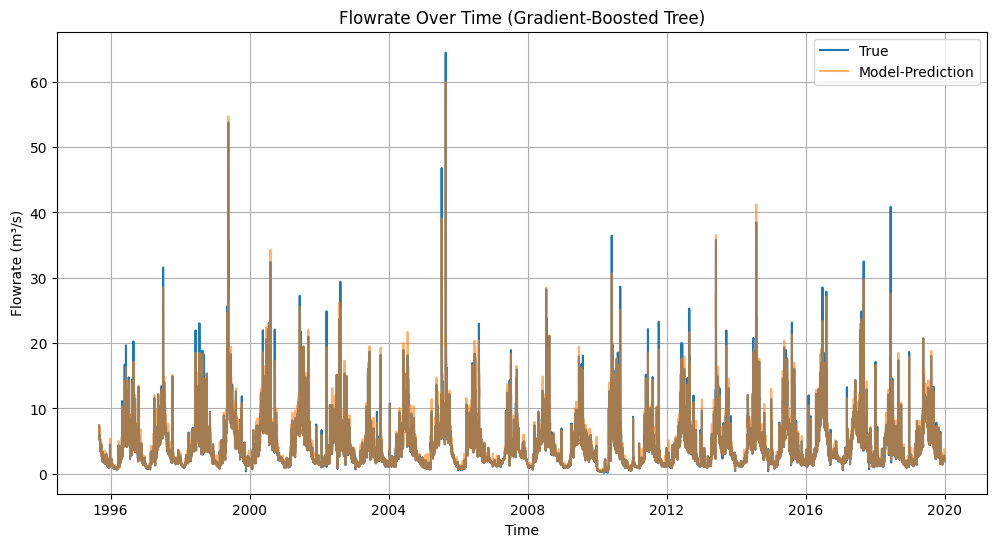

In [ ]:
# Plot the prediction over time
# Compare the value of prediction with true value of discharge
plt.figure(figsize=(12, 6))
plt.plot(y,label='True')
plt.plot(y_hat_GBC,label='Model-Prediction',alpha=0.6)
plt.title('Flowrate Over Time (Gradient-Boosted Tree)')
plt.xlabel('Time')
plt.ylabel('Flowrate (m³/s)')
plt.legend()
plt.grid(True)
plt.show()

## 4. Neural Network

### 4.1. Neural Network

In [ ]:
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();

plot_losses = PlotLosses()

Wir werden das Modell mit verschiedenen Werten für die lagged-time Werte testen und sehen, welches den geringsten Testfehler aufweist.

In [ ]:
columns_to_drop2= ['pr_24h_before','pr_12h_before','pr_9h_before','pr_3h_before','pr_36h_before','pr_48h_before','pr_6h_before','fr_9h_before','fr_3h_before','fr_6h_before','fr_12h_before']
X=df_combined.drop(columns=columns_to_drop2)
y=X['fr_target']
X=X.drop('fr_target',axis=1)
print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

                     flow_rate  Precipitation  fr_24h_before
timestamp                                                   
1995-09-03 00:00:00      7.596            0.0          8.809
1995-09-03 01:00:00      7.562            0.0          8.750
1995-09-03 02:00:00      7.529            0.0          8.688
1995-09-03 03:00:00      7.495            0.0          8.626
1995-09-03 04:00:00      7.461            0.0          8.564


In [ ]:
print(X_train.shape)

(149280, 3)


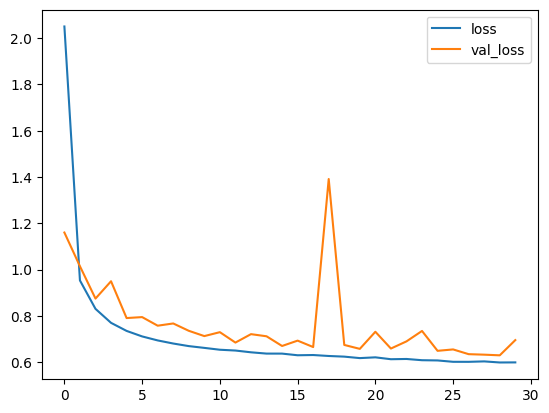

In [ ]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights=True)
NNRegModel=Sequential()

NNRegModel.add(InputLayer(input_shape=(3,)))
NNRegModel.add(Dense(10,activation='tanh',use_bias=True))
NNRegModel.add(Dense(1,use_bias=True))
sgd = SGD(learning_rate=0.3)
NNRegModel.compile(loss='mean_squared_error', optimizer='sgd')

NNRegModel.fit(X_train, y_train,
          shuffle=True,
          epochs=30, #300,
          batch_size=256,
          verbose=0,
          validation_data=(X_test, y_test),
          callbacks=[plot_losses,EarlyStopping])

In [ ]:
y_hat_tr_NN=NNRegModel.predict(X_train)
y_hat_test_NN=NNRegModel.predict(X_test)

2000/2000 [==============================] - 3s 1ms/step


In [ ]:
rmse_NN_tr = sqrt(mean_squared_error(y_hat_tr_NN,y_train))
rmse_NN_test = sqrt(mean_squared_error(y_hat_test_NN,y_test))

print('Trainingsfehler:',rmse_NN_tr)
print('Testfehler:',rmse_NN_test)

Trainingsfehler: 0.8123728555321078
Testfehler: 0.8338929058511498
(63978, 1)
(63978,)


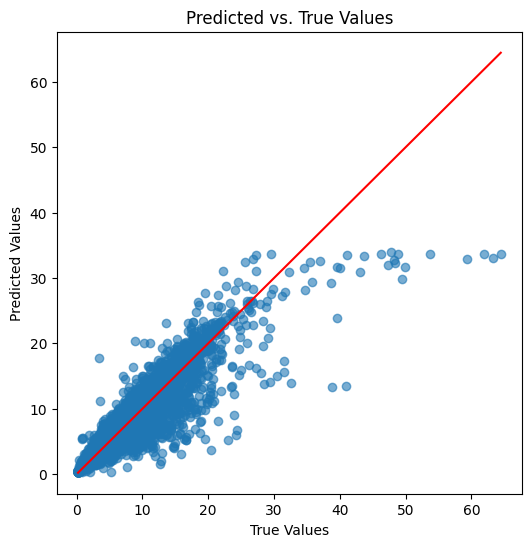

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test,y_hat_test_NN, alpha=0.6)
plt.title('Predicted vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')  # Diagonal line
plt.show()


In [ ]:
#Flatten predicted training- and test set array
y_hat_tr_NN = y_hat_tr_NN.ravel()
y_hat_test_NN = y_hat_test_NN.ravel()

#Combine predicted training- and test set array into one Series to plot graph
y_hat_NN1 = pd.Series(data=y_hat_tr_NN, index=y_train.index, name='fr_target')
y_hat_NN2 = pd.Series(data=y_hat_test_NN, index=y_test.index, name='fr_target')
y_hat_NN = pd.concat([y_hat_NN1, y_hat_NN2])
y_hat_NN.sort_index(inplace=True)

y_hat_NN

timestamp
1995-09-03 00:00:00    7.936630
1995-09-03 01:00:00    7.901248
1995-09-03 02:00:00    7.866779
1995-09-03 03:00:00    7.831271
1995-09-03 04:00:00    7.795727
                         ...   
2019-12-31 13:00:00    2.156352
2019-12-31 14:00:00    2.154028
2019-12-31 15:00:00    2.155072
2019-12-31 16:00:00    2.156298
2019-12-31 17:00:00    2.153716
Name: fr_target, Length: 213258, dtype: float32

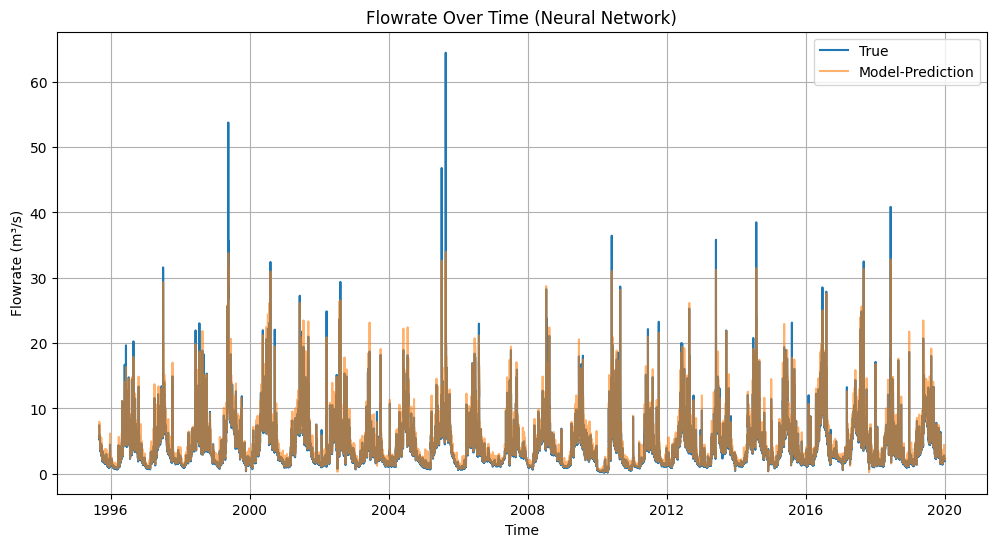

In [ ]:
#Plot the prediction over time
#Compare the value of prediction with true value of discharge
plt.figure(figsize=(12, 6))
plt.plot(y,label='True')
plt.plot(y_hat_NN,label='Model-Prediction',alpha=0.6)
plt.title('Flowrate Over Time (Neural Network)')
plt.xlabel('Time')
plt.ylabel('Flowrate (m³/s)')
plt.legend()
plt.grid(True)
plt.show()

### Without Early Stopping:
- 3 Input features: test error is 0.7847(Q24h)
- 4 Input features: test error is 0.8026(Q24h,Q12h)
- 5 Input features: test error is 0.7971(Q24h,Q12h,Q6h)
- 6 Input features: test error is 0.8347(Q24h,Q12h,Q6h,Q3h)
#### With more Input features the error is increasing, so we stick to 3
- Error with early stopping: 0.796, 3 Inputs

### 4.2. Recurrent Neural Net

In [ ]:
def create_input_sequences(data, N):
    X = []

    for i in range(len(data) - N):
        #Make 24h sequences for each data point
        sequence = data[i:(i + N)]
        X.append(sequence.to_numpy())

    return np.array(X)
N=24 #24 past Datapoints for each entry
X = create_input_sequences(X, N)

In [ ]:
print(X.shape)
print(y.shape)
y=y[:X.shape[0]] #there are 24 more data points in y now. thats we we cut 24 values
print(X.shape)
print(y.shape)
#X and y are same size now and X is prepared for the RNN :)

(213234, 24, 3)
(213258,)
(213234, 24, 3)
(213234,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

array([[[2.31 , 0.   , 2.425],
        [3.106, 0.   , 2.359],
        [2.478, 0.   , 2.469],
        ...,
        [2.314, 0.   , 2.477],
        [2.526, 0.   , 2.478],
        [2.36 , 0.   , 2.392]],

       [[3.08 , 0.3  , 2.706],
        [2.908, 0.4  , 2.748],
        [2.987, 1.   , 2.747],
        ...,
        [3.078, 0.3  , 2.978],
        [3.053, 0.1  , 3.003],
        [3.033, 0.   , 3.22 ]],

       [[7.051, 0.7  , 6.789],
        [7.049, 0.1  , 6.806],
        [7.046, 0.   , 6.822],
        ...,
        [7.18 , 0.   , 7.058],
        [7.222, 0.2  , 7.056],
        [7.264, 0.5  , 7.053]],

       ...,

       [[2.78 , 0.   , 3.36 ],
        [2.769, 0.   , 3.254],
        [2.78 , 0.   , 3.243],
        ...,
        [2.511, 0.   , 2.868],
        [2.39 , 0.   , 2.735],
        [2.412, 0.   , 2.748]],

       [[4.554, 0.   , 4.383],
        [4.608, 0.   , 4.383],
        [4.637, 0.   , 4.383],
        ...,
        [4.833, 0.   , 4.608],
        [4.833, 0.   , 4.522],
        [4.833,

In [ ]:
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

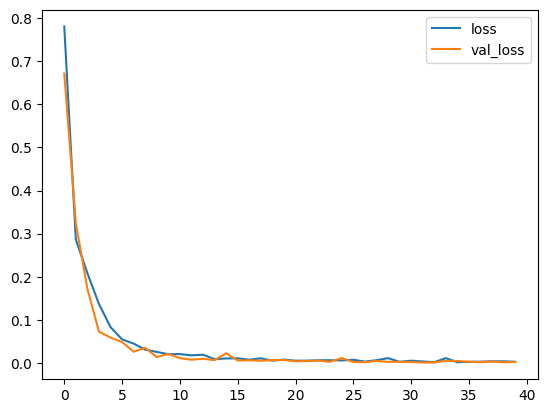

In [ ]:
history = model.fit(X_train, y_train, epochs=40, batch_size=256, validation_data=(X_test, y_test), verbose=0,callbacks=[plot_losses,EarlyStopping])


In [ ]:
y_hat_tr_RNN=model.predict(X_train)
y_hat_test_RNN=model.predict(X_test)

1333/1333 [==============================] - 5s 3ms/step


In [ ]:
rmse_RNN_tr = sqrt(mean_squared_error(y_hat_tr_RNN,y_train))
rmse_RNN_test = sqrt(mean_squared_error(y_hat_test_RNN,y_test))

print('Trainingsfehler:',rmse_RNN_tr)
print('Testfehler:',rmse_RNN_test)

Trainingsfehler: 0.036959995101083436
Testfehler: 0.05040117314413398


Mit einem Testfehler von ~0.05-0.07 ist das RNN das Top-Modell im Vergleich zu allen anderen Modellen.

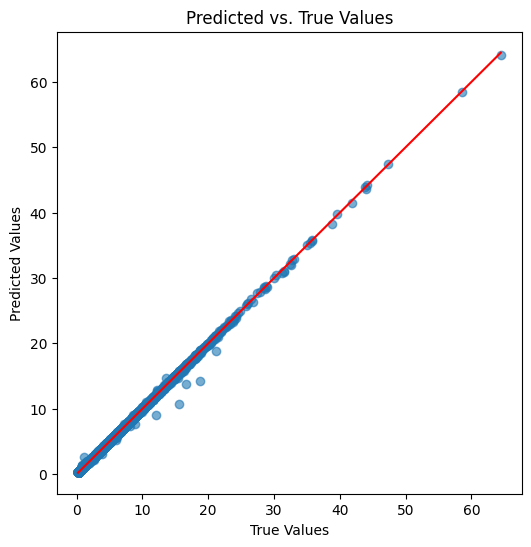

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test,y_hat_test_RNN, alpha=0.6)
plt.title('Predicted vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')  # Diagonal line
plt.show()


In [ ]:
# Flatten predicted training- and test set array
y_hat_tr_RNN = y_hat_tr_RNN.ravel()
y_hat_test_RNN = y_hat_test_RNN.ravel()

# Combine predicted training- and test set into one Series to plot graph
y_hat_RNN1 = pd.Series(data=y_hat_tr_RNN, index=y_train.index, name='fr_target')
y_hat_RNN2 = pd.Series(data=y_hat_test_RNN, index=y_test.index, name='fr_target')
y_hat_RNN = pd.concat([y_hat_RNN1, y_hat_RNN2])
y_hat_RNN.sort_index(inplace=True)
y_hat_RNN

timestamp
1995-09-03 00:00:00    7.386122
1995-09-03 01:00:00    7.352549
1995-09-03 02:00:00    7.318315
1995-09-03 03:00:00    7.283371
1995-09-03 04:00:00    7.247744
                         ...   
2019-12-30 13:00:00    2.011019
2019-12-30 14:00:00    2.008819
2019-12-30 15:00:00    1.969141
2019-12-30 16:00:00    1.970997
2019-12-30 17:00:00    1.967292
Name: fr_target, Length: 213234, dtype: float32

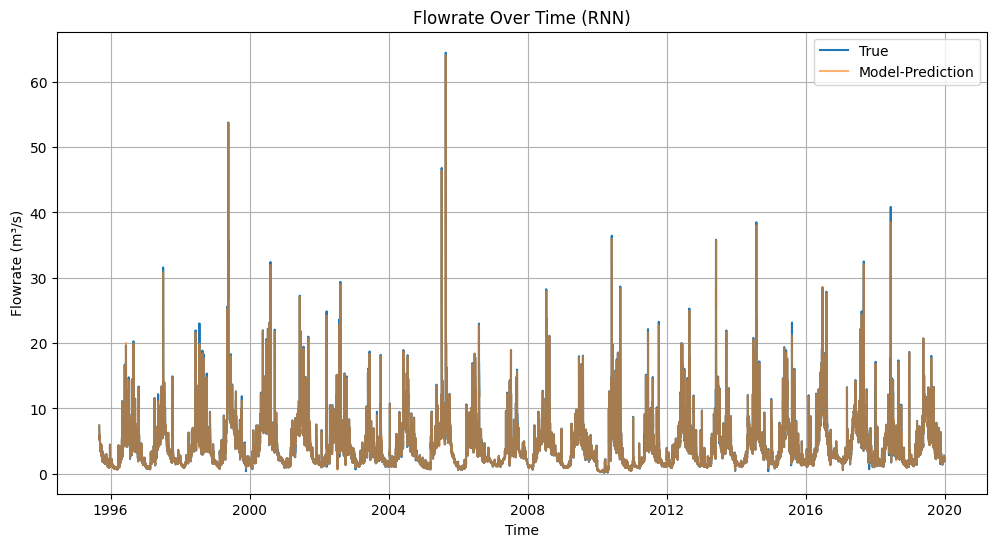

In [ ]:
# Plot the prediction over time
# Compare the value of prediction with true value of discharge
plt.figure(figsize=(12, 6))
plt.plot(y,label='True')
plt.plot(y_hat_RNN,label='Model-Prediction',alpha=0.6)
plt.title('Flowrate Over Time (RNN)')
plt.xlabel('Time')
plt.ylabel('Flowrate (m³/s)')
plt.legend()
plt.grid(True)
plt.show()

Wie erwartet, passen die von RNN vorhergesagten Werte fast perfekt zum Graphen der tatsächlichen Werte.

#### 4.2.1. RNN mit k-fold-Crossvalidation

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
fold = 1
rmse_scores_train = []
rmse_scores_test = []

for train_index, val_index in tscv.split(X):
    print(f"Fold {fold}")

    #Split the data
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test= y[train_index], y[val_index]

    #Define the RNN model
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    #Train the model
    model.fit(X_train, y_train, epochs=30,batch_size=256,verbose=0,validation_data=(X_test, y_test))

    #Predict
    y_hat_tr_RNN=model.predict(X_train)
    y_hat_test_RNN=model.predict(X_test)

    #Evaluate the model
    rmse_RNN_tr = sqrt(mean_squared_error(y_hat_tr_RNN,y_train))
    rmse_RNN_test = sqrt(mean_squared_error(y_hat_test_RNN,y_test))
    rmse_scores_train.append(rmse_RNN_tr)
    rmse_scores_test.append(rmse_RNN_test)
    print(f"Fold {fold} RMSE: {rmse_scores_test}")

    fold += 1

# Calculate the average RMSE over all folds
average_rmse_train = np.mean(rmse_scores_train)
average_rmse_test=np.mean(rmse_scores_test)
print(f"Average RMSE-Train-score across all folds: {average_rmse_train}")
print(f"Average RMSE-Test-score across all folds: {average_rmse_test}")

Fold 1
1111/1111 [==============================] - 4s 3ms/step
Fold 1 RMSE: [0.3354383797464448]
Fold 2
1111/1111 [==============================] - 4s 3ms/step
Fold 2 RMSE: [0.3354383797464448, 0.09436423281503457]
Fold 3
1111/1111 [==============================] - 4s 4ms/step
Fold 3 RMSE: [0.3354383797464448, 0.09436423281503457, 0.06912178795377763]
Fold 4
1111/1111 [==============================] - 4s 4ms/step
Fold 4 RMSE: [0.3354383797464448, 0.09436423281503457, 0.06912178795377763, 0.6985865242184907]
Fold 5
1111/1111 [==============================] - 3s 3ms/step
Fold 5 RMSE: [0.3354383797464448, 0.09436423281503457, 0.06912178795377763, 0.6985865242184907, 0.10804378921074458]
Average RMSE-Train-score across all folds: 0.22840640640493484
Average RMSE-Test-score across all folds: 0.26111094278889846
